Content

End goal of this study is to figure out a way to scan the elements in a given web page and identify them as textbox, buttons etc. Once identified, write test cases in selenium to automate UI testing.

It would be also good to identify the allignment and write appropriate testcases to test the field allignments.

LandingAI is pretty popular in the computer vision model sector so that was the first choice for evaluation but it turned out that the model was specifically good for domain-specific images and visionagent was not giving accurate results for our specific usecase.

That's when the search expanded to huggingface's opensource models.

Following the norm, we are focussed on using models that has its weights in MBs so the model can be run on laptop smoothly.
weight X 0.2 = memory needed (check file pytorch-model.bin)

There are several technologies and tools that can scan images and identify the elements within them. These technologies fall under the category of Computer Vision and often use Deep Learning techniques to analyze and understand images. Some of the most common methods and tools include:

Object Detection:

YOLO (You Only Look Once): A popular real-time object detection algorithm that can identify multiple objects in an image with bounding boxes.
Faster R-CNN: Another well-known object detection framework that provides high accuracy in identifying objects within images.
SSD (Single Shot MultiBox Detector): A method that balances speed and accuracy in object detection.
Image Segmentation:

Mask R-CNN: Extends Faster R-CNN by adding a branch for predicting segmentation masks, allowing it to delineate objects at the pixel level.
U-Net: Often used for medical imaging, it is effective in performing precise image segmentation.
Optical Character Recognition (OCR):

Tesseract: An open-source OCR engine that can recognize text in images.
Google Cloud Vision API: Offers OCR capabilities that can extract text from images.
Scene Understanding and Image Captioning:

Microsoft Azure Cognitive Services: Provides APIs for analyzing images and identifying objects, faces, and other elements. It can also generate captions for images.
Google Cloud Vision API: Detects objects, landmarks, and can even provide labels and descriptions for images.
AI/ML Frameworks and Libraries:

TensorFlow & PyTorch: Both offer pre-trained models and libraries that can be used to build custom image recognition and object detection models.
OpenCV: A popular computer vision library that provides tools for processing and analyzing images.
Custom Solutions:

If you have specific needs, you can train a custom model using these tools and frameworks to identify particular elements in images.
These technologies are widely used in various applications, including autonomous vehicles, surveillance systems, medical imaging, and more.

https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard
https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard

## Step 1: Object Detection

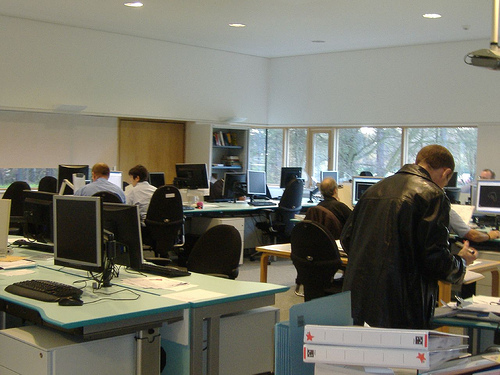

In [1]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/test-stuff2017/000000000442.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [2]:

from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

encoding = processor(image, return_tensors="pt")
encoding.keys()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['pixel_values', 'pixel_mask'])

In [3]:
print(encoding['pixel_values'].shape)


torch.Size([1, 3, 800, 1066])


In [4]:

from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:

import torch

# using torch.no_grad() will save you memory
# as we don't need gradients during inference time
with torch.no_grad():
  outputs = model(**encoding)

In [6]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [7]:

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]

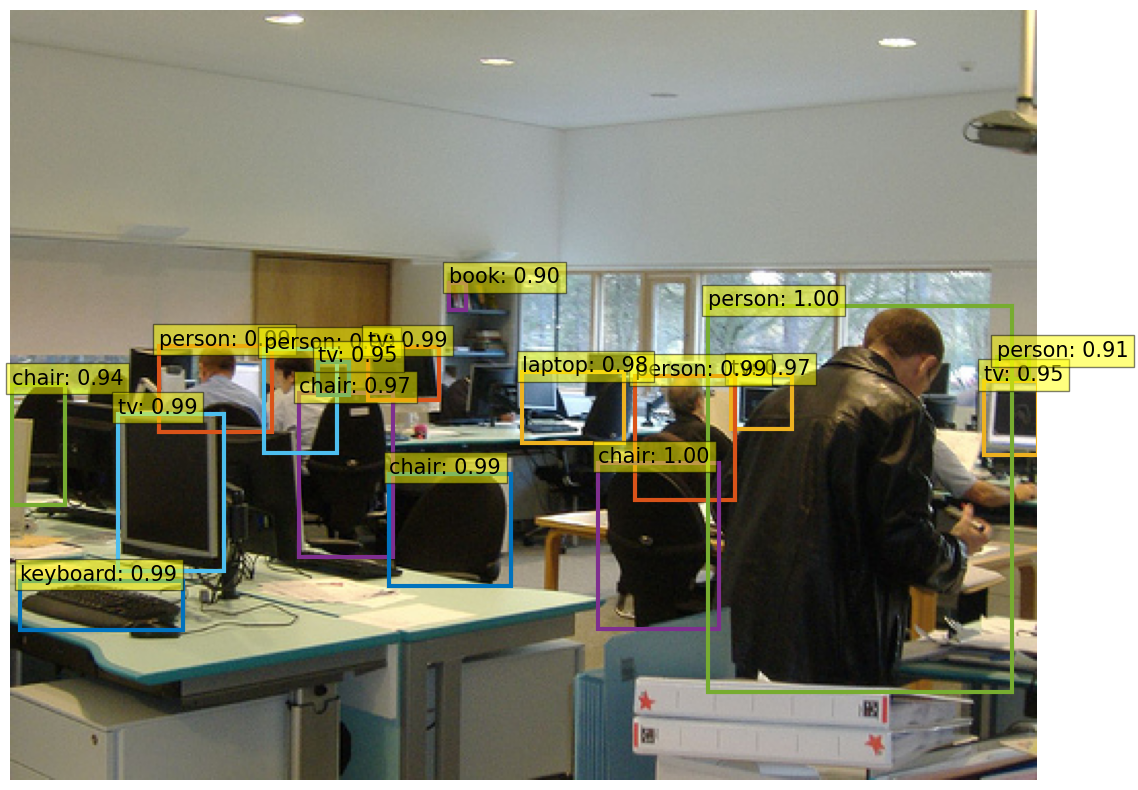

In [8]:
plot_results(image, results['scores'], results['labels'], results['boxes'])


## Step 2: Visual Q&A

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings("ignore", message="Using the model-agnostic default `max_length`")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import BlipForQuestionAnswering

In [5]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

In [6]:
from transformers import AutoProcessor

In [7]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


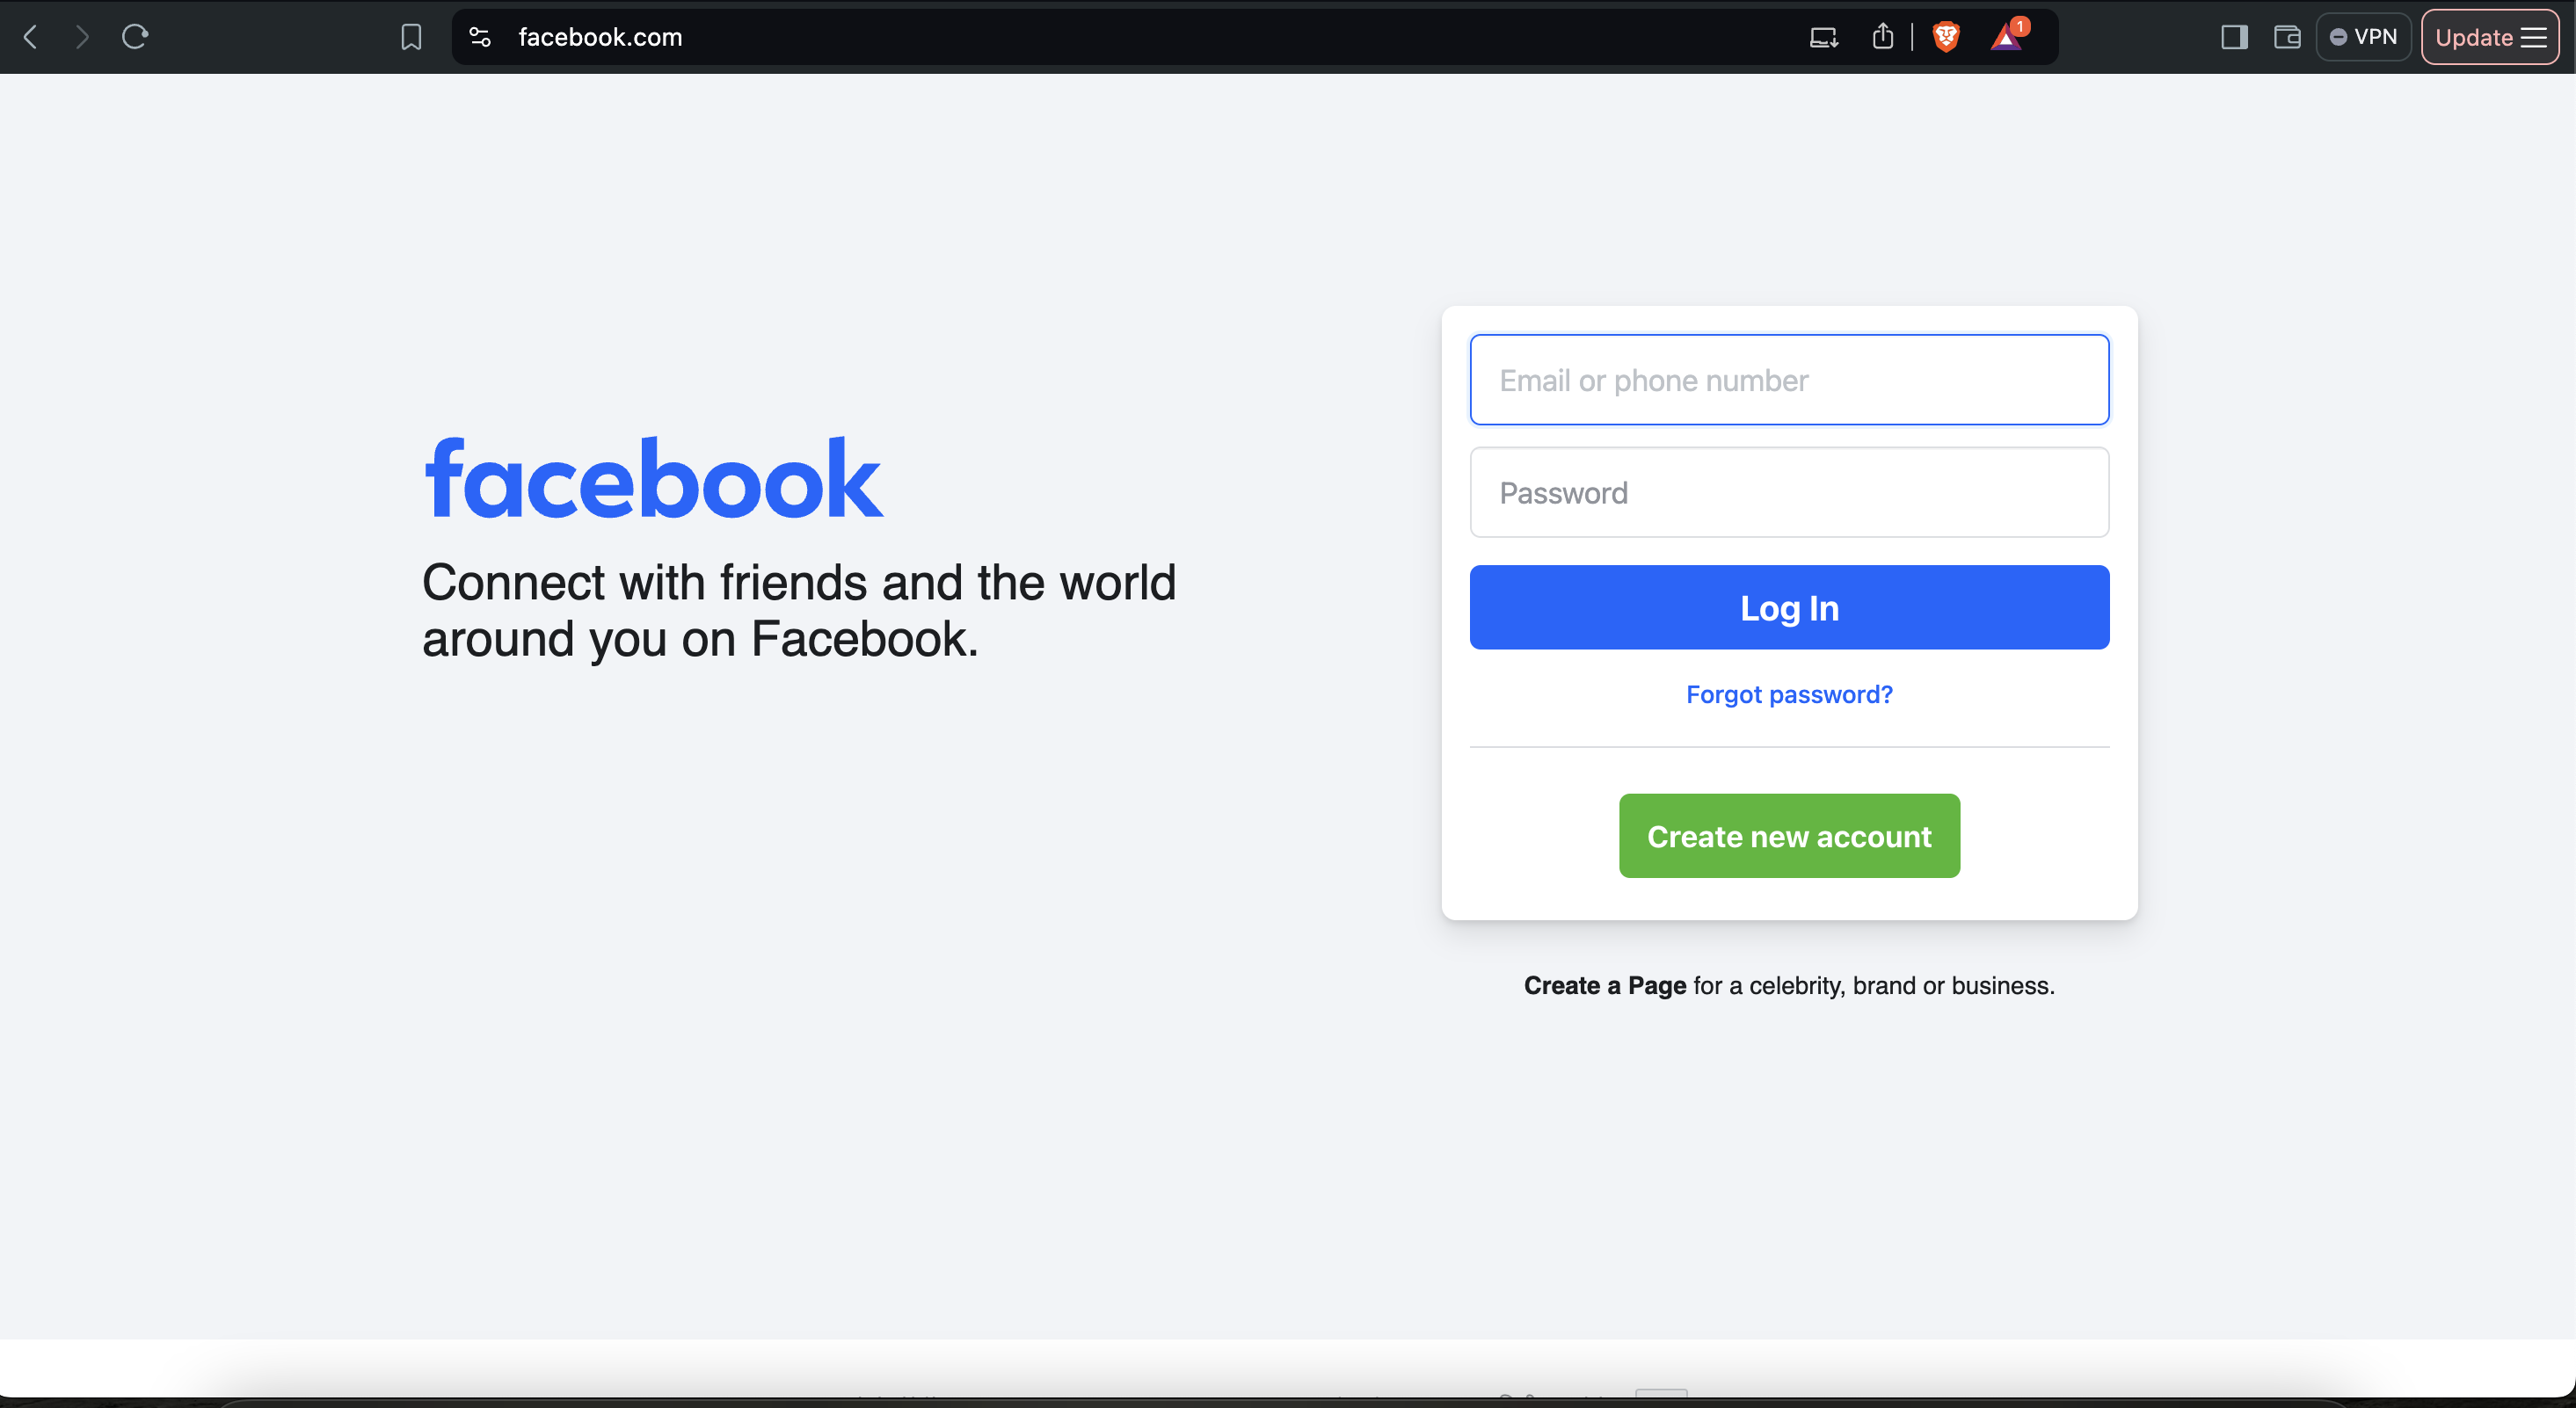

In [10]:
from PIL import Image
image = Image.open("xxx.png")
image

In [19]:
question = "What is the name of textbox in the picture?"

In [20]:
inputs = processor(image, question, return_tensors="pt")

In [21]:
out = model.generate(**inputs)

In [22]:
print(processor.decode(out[0], skip_special_tokens=True))

facebook
